In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from collections import defaultdict
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

from torchvtk.utils import make_4d, make_5d, tex_from_pts
from torchvtk.rendering import plot_tf

from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D
from torchviz import make_dot

from rle_shit import decode_from_annotation
from moco import MoCo

pltkwargs = {
    'dpi':  200,
    'tight_layout': True
}

In [24]:
data = torch.load('/run/media/dome/Data/data/Volumes/CT-ORG/torch/volume_010.pt')
vol = data['vol'].float()
mask = data['mask']

In [25]:
vol.shape, vol.dtype, vol.min(), vol.max()

(torch.Size([512, 512, 501]), torch.float32, tensor(-1024.), tensor(1602.))

Text(0.5, 1.0, 'Sliced along Z')

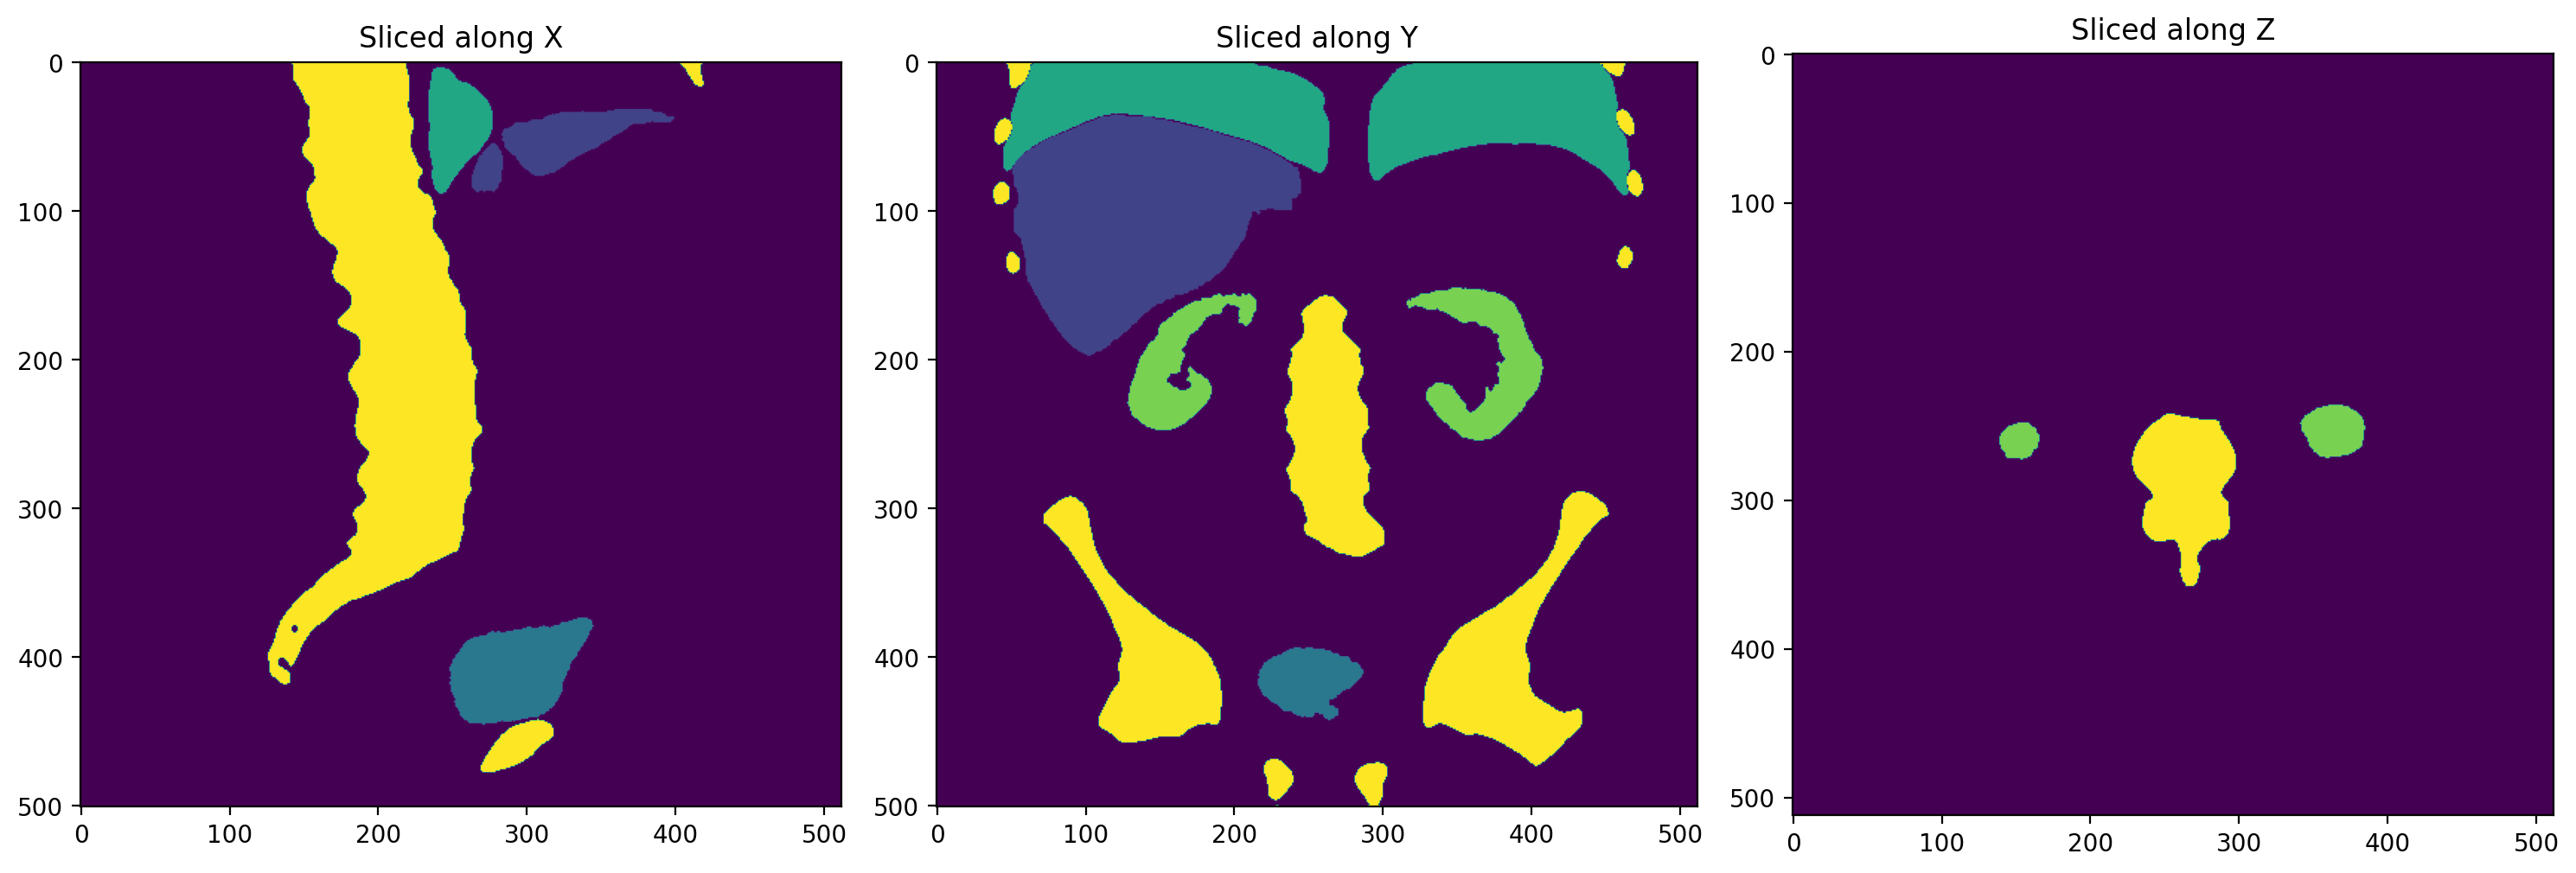

In [27]:
fig, ax = plt.subplots(1,3, figsize=(15,5), **pltkwargs)
ax[0].imshow(vol[250, :, :].rot90())
ax[0].set_title('Sliced along X')
ax[1].imshow(vol[:, 256, :].rot90())
ax[1].set_title('Sliced along Y')
ax[2].imshow(vol[:, :, 256].rot90())
ax[2].set_title('Sliced along Z')


In [2]:
def create_cnn():
    return nn.Sequential(
        nn.GroupNorm(1, 1),
        nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.GroupNorm(8, 8),
        nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.GroupNorm(8, 16),
        nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
    )

In [3]:
n_samples = 4096
samples_per_class = n_samples // num_classes
BG_CLASS = 'background'
sample_idxs = { # Dict classname: (2, samples_per_class) indices into class_indices
    n: even_len(torch.randperm(l.size(0))[:2*samples_per_class]).reshape(2, -1)
    for n,l in class_indices.items() if n != BG_CLASS
}
assert len(sample_idxs) == num_classes - 1
bg_samples = n_samples - sum(v.size(1) for v in sample_idxs.values())
sample_idxs[BG_CLASS] = torch.randperm(class_indices[BG_CLASS].size(0))[:2*bg_samples].reshape(2, -1)
# Actually grab the voxel locations, both being dict classname: (samples_per_class, 3)
samples_a = { n: class_indices[n][idx[0]] for n, idx in sample_idxs.items() }
samples_b = { n: class_indices[n][idx[1]] for n, idx in sample_idxs.items() }
# (N, 3)
idxs_a, idxs_b = torch.cat(list(samples_a.values()), dim=0), torch.cat(list(samples_b.values()), dim=0)

NameError: name 'num_classes' is not defined

In [4]:
def make_even(n):
    if n % 2 == 0: return n
    else:          return n-1

def split_squeeze(t, bs, f):
    n = t.size(0)
    X, Y, Z = t[None, None].expand(bs, f, n, 3).split(1, dim=-1)
    BS = torch.arange(bs)[:, None, None].expand(bs, f, n)
    F =  torch.arange(f)[None, :, None].expand(bs, f, n)
    return (BS, F, X.squeeze(-1), Y.squeeze(-1), Z.squeeze(-1))

## SimCLR train loop

In [5]:
# Setup
BG_CLASS = 'background'
N_SAMPLES = 4096
FP16 = True
HALF_RES = True

# Model
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
typ = torch.float16 if FP16 else torch.float32
model = create_cnn().to(dev)
ONE = torch.ones(1, device=dev)

# Data
data = torch.load(
    '/run/media/dome/Data/data/Volumes/CT-ORG/torch/volume_010.pt')
if HALF_RES:
    vol  = F.interpolate(make_5d(data['vol']).float(), scale_factor=0.25, mode='nearest').squeeze().to(typ).to(dev)
    mask = F.interpolate(make_5d(data['mask']),        scale_factor=0.25, mode='nearest').squeeze()
else:
    vol  = data['vol'].to(typ).to(dev)
    mask = data['mask']

num_classes = len(data['labels'])
class_indices = {
    n: (mask == i).nonzero().to(dev)
    for i, n in enumerate(data['labels'])
}
samples_per_class = N_SAMPLES // num_classes
sample_idxs = {  # Dict classname: (2, samples_per_class) indices into class_indices
    n: make_even(l.size(0))
    for n, l in class_indices.items() if n != BG_CLASS
}
assert len(sample_idxs) == num_classes - 1
bg_samples = N_SAMPLES - sum(v for v in sample_idxs.values())

In [69]:
sample_idxs, bg_samples, samples['lung'].shape

({'liver': 45050,
  'bladder': 5020,
  'lung': 60848,
  'kidney': 9854,
  'bone': 67780,
  'brain': 0},
 -184456,
 torch.Size([585]))

In [71]:
# Optimize
scaler = torch.cuda.amp.GradScaler()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []
preds = []
for i in range(1001):
    opt.zero_grad()
    # 1 Feed volume thru networks
    with torch.autocast('cuda', enabled=True, dtype=typ):
        features = model(make_5d(vol))
        q = F.normalize(features, dim=1)
    # 2 Choose samples from classes
    BS, FS = q.size(0), q.size(1)
    samples = { # Pick samples_per_class indices to `class_indices`
        n: torch.multinomial(ONE.expand(v), samples_per_class)
        for n,v in sample_idxs.items() if v >= samples_per_class
    }
    bgs = torch.multinomial(ONE.expand(class_indices['background'].size(0)), N_SAMPLES - sum(s.size(0) for s in samples.values()))
    bg_feats = q[split_squeeze(class_indices['background'][bgs], bs=BS, f=FS)]
    # 3 Sample samples
    loss = 0.0
    for n, idx in samples.items():
        negs = torch.cat([class_indices[c][s] for c, s in samples.items() if c != n], dim=0)
        pos = q[split_squeeze(class_indices[n][idx], bs=BS, f=FS)]
        neg = q[split_squeeze(negs,                  bs=BS, f=FS)]
        pos_center = torch.mean(pos, dim=(0,2))[None, :, None].expand(BS, -1, 1)
        sim = torch.einsum('bfp,bfn->bpn', [pos, torch.cat([pos_center, neg, bg_feats], dim=-1)])
        print(sim.shape)
        sim = sim.reshape(-1, neg.size(-1) + bg_feats.size(-1) + 1)
        labels = torch.zeros(sim.size(0), dtype=torch.long, device=dev)
        loss += F.cross_entropy(sim, labels)

    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()

    # Valid
    if i % 100 == 0:
        with torch.no_grad():
            losses.append(loss.detach().cpu().item())
            km = KMeans(n_clusters=num_classes)
            km.fit(features.permute(0, 2, 3, 4, 1).reshape(-1, features.size(1)).cpu())
            pred = km.labels_.reshape(*features.shape[-3:])
            preds.append(pred)

torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
torch.Size([1, 585, 3512])
t

In [ ]:
def assemble_pos_neg(q, class_indices)

In [72]:
cluster_centers = {}
for n, idx in class_indices.items():
    cluster_centers[n] = features.detach()[split_squeeze(idx, bs=features.size(0), f=features.size(1))].mean(dim=(0,2))

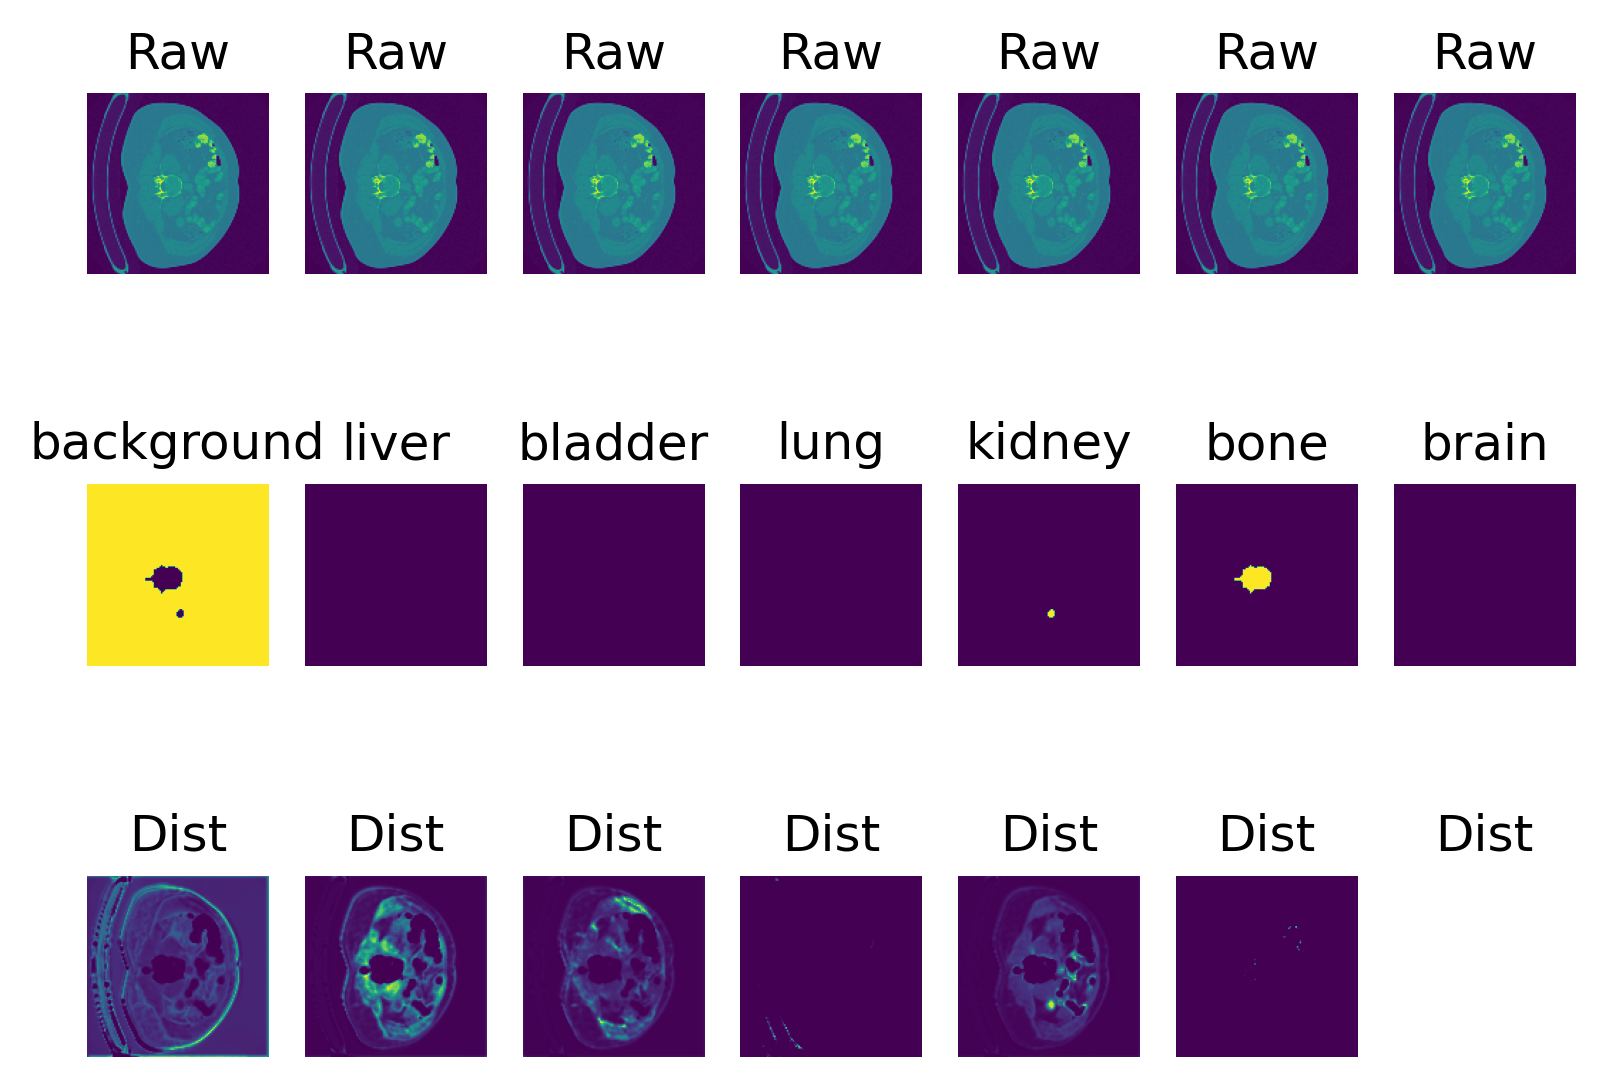

In [73]:
fig, ax = plt.subplots(3,num_classes, dpi=300)
vol_slice = vol.detach().squeeze()[:,:,62]
mask_slice = mask.detach().squeeze()[:, :, 62]
feat_slice = features.detach().squeeze()[:, :, :, 62]
for i, cc in enumerate(cluster_centers.items()):
    n, center = cc
    ax[0,i].imshow(vol_slice.cpu())
    ax[0,i].set_title(f'Raw')
    ax[1,i].imshow(mask_slice.cpu() == i)
    ax[1,i].set_title(n)
    ax[2,i].imshow(torch.exp(-(feat_slice - center[:,None,None]).norm(dim=0)).cpu())
    ax[2,i].set_title(f'Dist')
for x in ax.reshape(-1): x.set_axis_off()

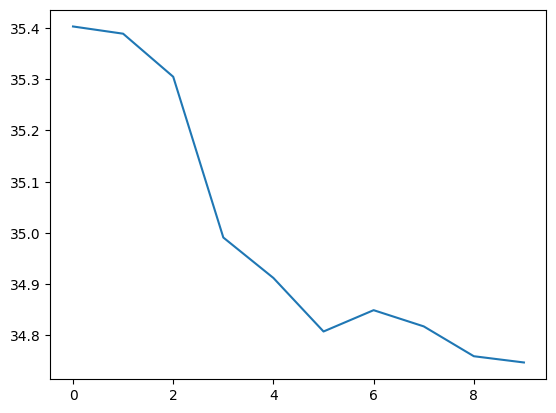

In [24]:
plt.plot(losses)

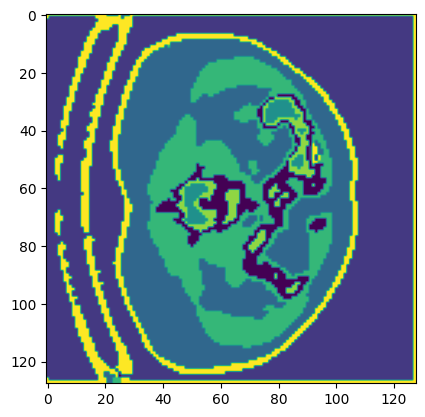

In [26]:
plt.imshow(preds[0][:,:,62])

In [32]:
mask.max(), preds[0].max()

(tensor(5, dtype=torch.uint8), 6)

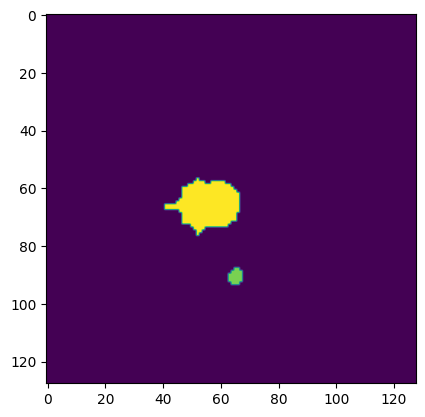

In [29]:
plt.imshow(mask.detach().squeeze().cpu()[:,:,62])

In [21]:
from sklearn.cluster import KMeans

In [20]:
sim.shape, neg.shape

(torch.Size([585, 2341]), torch.Size([1, 16, 2340]))

In [11]:
torch.mean(pos, dim=(0,2)).shape

torch.Size([16])

In [7]:
idx.shape

torch.Size([585])

In [42]:
class_indices['brain'].shape, idx.shape

(torch.Size([0, 3]), torch.Size([585]))

In [38]:
idx.sha 

AttributeError: 'Tensor' object has no attribute 'sha'

In [7]:
pos.shape, neg.shape

(torch.Size([1, 16, 585]), torch.Size([1, 16, 2340]))

In [20]:
negs.shape

torch.Size([2002950, 3])

In [18]:
a = torch.randn(1,2, 10,10,10)
b = torch.randn(     10,10,10)
ind_z, ind_y, ind_x = (b > 0).nonzero(as_tuple=True)
ind_bs = torch.arange(a.size(0))[:, None, None].expand(-1, a.size(1),
                                                       ind_z.size(0))
ind_f = torch.arange(a.size(1))[None, :, None].expand(a.size(0), -1, 
                                                       ind_z.size(0))
a[ind_bs, ind_f, ind_z, ind_y, ind_x].shape

torch.Size([1, 2, 468])

In [11]:
tup = (a > 0).nonzero(as_tuple=True)

In [12]:
tupk

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5

In [10]:
a = torch.randn(10,10,10)
b[(a > 0).nonzero(as_tuple=True)].shape

TypeError: only integer tensors of a single element can be converted to an index

In [86]:
class_indices[n].dtype

torch.int64

In [87]:
print(tuple(map(lambda a: (a.shape, a.dtype), split_squeeze(negs))))

((torch.Size([2002950]), torch.int64), (torch.Size([2002950]), torch.int64), (torch.Size([2002950]), torch.int64))


In [62]:
tuple(map(lambda a: a.shape, class_indices['lung'].split(1, dim=-1)))

(torch.Size([60848, 1]), torch.Size([60848, 1]), torch.Size([60848, 1]))

In [57]:
{ k: v.max().item() < sample_idxs[k] for k,v in samples.items() }

{'liver': True, 'bladder': True, 'lung': True, 'kidney': True, 'bone': True}

In [52]:
{ k: torch.multinomial(ONE.expand(v), samples_per_class) for k,v in sample_idxs.items() if v>= samples_per_class}

{'liver': tensor([12476, 33443,   743,  9071, 25975,  2679,  5603, 40191, 14721, 20423,
          8845, 25661, 25660, 13853,  3844, 19398,  5093, 16113,  5663, 12501,
         28819, 11393,  9288, 30077, 31544, 26161, 16806, 35256, 13771, 15480,
           624, 24874, 44840, 44149, 25399, 32399, 24753, 29553, 14630,  8680,
         42646,  9676,  7592, 37478, 38397, 21788, 19230, 31343, 27552, 10132,
         43479,  5370, 29464, 29741,  2014,  7307, 40094, 33913, 10082,  2459,
         26898, 12989, 10149,  6930, 35482, 17093, 38123,  5829, 26986,   725,
         14916,  3209,  5781,  4861,  2115, 13369, 40292, 43127, 43894, 33367,
         28875, 26677, 44927, 12619, 11831, 23588, 13581, 11024, 24434, 19143,
         35267,  1374, 27501, 44200, 17904, 37527, 24996, 29463, 18482, 37759,
         10373, 25801, 37185, 14894, 38674, 44406, 31534, 32063,  4664, 31211,
          6987,  8979, 23456, 22103, 32240, 21856, 20439, 29007, 23867, 43704,
         34006,  7368, 37040, 13090, 28179,

In [42]:
print(sample_idxs, samples_per_class)

{'liver': 45050, 'bladder': 5020, 'lung': 60848, 'kidney': 9854, 'bone': 67780, 'brain': 0} 585


In [46]:
{ k: v.shape for k,v in class_indices.items() }

{'background': torch.Size([1859446, 3]),
 'liver': torch.Size([45050, 3]),
 'bladder': torch.Size([5020, 3]),
 'lung': torch.Size([60848, 3]),
 'kidney': torch.Size([9855, 3]),
 'bone': torch.Size([67781, 3]),
 'brain': torch.Size([0, 3])}

In [9]:
torch.cat(list(samples.values()), dim=1).shape

torch.Size([2, 2925])

In [32]:
idxx = class_indices['lung'][samples['lung']][0]

In [36]:
vol[idxx.split(1, dim=-1)].shape

torch.Size([585, 1])

In [19]:
torch.multinomial(torch.ones(1000), 100).cuda()

tensor([252, 133, 956, 566, 713, 681, 854, 638, 386,  57, 406, 476, 869, 743,
        542, 100, 689,  79, 625, 795, 515, 902, 836,  52, 315,  65, 471, 712,
        460, 901, 126, 700, 506, 617, 582, 834, 362, 435, 621, 925, 603, 268,
        464, 600, 963, 422, 241, 645, 481, 563, 191, 383, 845,  26, 886, 856,
        169, 267,  21, 939, 981, 683, 441, 950,  10, 324, 539, 918, 786, 257,
         92, 209, 229, 396,  23,  45, 240, 626, 732, 430, 486, 452, 458, 652,
         42, 862, 319, 850, 661, 624, 874, 262, 654, 634, 482, 557,  55, 373,
        782,  24], device='cuda:0')

In [20]:
ONE = torch.ones(1, device='cuda')

In [21]:
torch.multinomial(ONE.expand(1000), 100)

tensor([870, 228, 894, 464, 922, 801, 828, 180, 207, 871, 599, 969, 749, 512,
        656, 880, 746, 804, 867, 320, 678, 315, 446, 928, 724, 492, 594,  84,
        778, 424, 129, 776,  31, 817, 445, 849, 761, 666, 284, 758, 914, 332,
         14,  45, 413, 809, 345, 275, 386, 848, 542,  52, 181, 379, 432, 568,
        361,   7, 994, 453, 279, 662, 122, 111, 959, 371, 410, 323,  20, 297,
        691, 586, 244, 908, 834,   1, 439, 729,  91, 841, 176, 869, 108, 444,
        399, 832, 744, 200, 344, 980, 376, 822, 836, 259, 502, 419,  43, 862,
        340,   0], device='cuda:0')

In [11]:
vol.shape, vol.dtype

(torch.Size([256, 256, 250]), torch.float16)

In [7]:
sample_idxs

{'liver': 2881676,
 'bladder': 321402,
 'lung': 4000562,
 'kidney': 629942,
 'bone': 4351436,
 'brain': 0}

In [118]:
{n: v.shape for n,v in samples_a.items()}

{'liver': torch.Size([585, 3]),
 'bladder': torch.Size([585, 3]),
 'lung': torch.Size([585, 3]),
 'kidney': torch.Size([585, 3]),
 'bone': torch.Size([585, 3]),
 'brain': torch.Size([0, 3]),
 'background': torch.Size([1171, 3])}

In [101]:
bg_samples

1171

In [91]:
idxs_a.shape, idxs_b.shape

(torch.Size([3510, 3]), torch.Size([3510, 3]))

In [81]:
print({ k: v.shape for k,v in samples_a.items()})

{'background': torch.Size([585, 3]), 'liver': torch.Size([585, 3]), 'bladder': torch.Size([585, 3]), 'lung': torch.Size([585, 3]), 'kidney': torch.Size([585, 3]), 'bone': torch.Size([585, 3])}


In [69]:
print({k: v.shape for k,v in sample_pairs.items()})

{'background': torch.Size([2, 585]), 'liver': torch.Size([2, 585]), 'bladder': torch.Size([2, 585]), 'lung': torch.Size([2, 585]), 'kidney': torch.Size([2, 585]), 'bone': torch.Size([2, 585])}


In [79]:
samples_idxs_a, samples_idxs_b = torch.cat(list(sample_pairs.values()), dim=1)

In [78]:
samples_a, samples_b = 

torch.Size([3510])

In [54]:
samples_a, samples_b = zip(*sample_pairs)

ValueError: not enough values to unpack (expected 2, got 1)

In [52]:
samples_a, samples_b = zip(*[tuple(ci[a], ci[b]) for ci, (a, b) in zip(class_indices, sample_pairs)])

TypeError: tuple expected at most 1 argument, got 2

In [38]:
with torch.no_grad():
    logits, labels, features = moco_model(vol.cuda())

TypeError: MoCo.forward() missing 3 required positional arguments: 'im_k', 'correspondence_q', and 'correspondence_k'

In [32]:
feats = { k: feat[:, :, mask] for k,mask in masks_half.items() }

In [36]:
feat.std()

tensor(0.2999, device='cuda:0')

In [35]:
print({k: torch.std(v) for k,v in feats.items() })

{'Lung': tensor(0.2883, device='cuda:0'), 'Skin': tensor(0.4729, device='cuda:0'), 'Bone': tensor(0.3621, device='cuda:0'), 'Meat': tensor(0.2458, device='cuda:0')}


In [37]:
model

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        

In [42]:
from moco import MoCo

In [40]:
from functools import partial

In [43]:
mocmodel = MoCo(partial(UNet3D, 1, 32), 32, {
    'final_sigmoid': False,
    'f_maps': 16,
    'is_segmentation': False}
)


In [44]:
from torchvision.transforms import RandomRotation

In [45]:
rot = RandomRotation(15.0)
torch.meshgrid(torch.linspace(-1, 1, 64))
cor_grid = rot(torch)

In [ ]:
logits, labels = mocmodel(torch.randn(2, 1, 64,64,64), torch.randn(2,1, 64,64,64))